In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pic-test/test2.jpg
/kaggle/input/pic-test/test1.jpg
/kaggle/input/pic-test2/test3.jpg
/kaggle/input/covid-pneumonia-multiclass/README.dataset.txt
/kaggle/input/covid-pneumonia-multiclass/README.roboflow.txt
/kaggle/input/covid-pneumonia-multiclass/valid/00000815_000_png.rf.4ed8aed2c0349063e2078dd57cea379d.jpg
/kaggle/input/covid-pneumonia-multiclass/valid/00000334_005_png.rf.148838c532d6cef930540ad80d312b13.jpg
/kaggle/input/covid-pneumonia-multiclass/valid/00017652_000_png.rf.8169587c54e9cd8d941c3c185dbec4c2.jpg
/kaggle/input/covid-pneumonia-multiclass/valid/COVID-19-13-_jpeg.rf.4ec861745c87415128d0b299066f4ceb.jpg
/kaggle/input/covid-pneumonia-multiclass/valid/00001231_001_png.rf.82dc2a20402d9d95c234a12a9add5889.jpg
/kaggle/input/covid-pneumonia-multiclass/valid/person549_bacteria_2306_jpeg.rf.57ad7cd22c85def7d9737785e23a8445.jpg
/kaggle/input/covid-pneumonia-multiclass/valid/00000569_003_png.rf.6d3f5999b729f85b9d64d85b5fa98623.jpg
/kaggle/input/covid-pneumonia-multicla

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import timm
import seaborn as sns
import zipfile
import random
from transformers import ViTForImageClassification

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
2025-04-29 15:26:51.100022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745940411.283321     117 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745940411.334465     117 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def load_data(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    df.columns = ['filename', 'covid', 'normal', 'pneumonia']
    image_paths = [os.path.join(images_dir, fname) for fname in df['filename']]
    labels = df[['covid', 'normal', 'pneumonia']].values.argmax(axis=1)
    return image_paths, labels

In [4]:
class XRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [5]:
base_path = '/kaggle/input/covid-pneumonia-multiclass'
train_csv = os.path.join(base_path, 'train', '_classes.csv')
valid_csv = os.path.join(base_path, 'valid', '_classes.csv')
test_csv = os.path.join(base_path, 'test', '_classes.csv')

train_images_dir = os.path.join(base_path, 'train')
valid_images_dir = os.path.join(base_path, 'valid')
test_images_dir = os.path.join(base_path, 'test')

In [6]:
train_paths, train_labels = load_data(train_csv, train_images_dir)
valid_paths, valid_labels = load_data(valid_csv, valid_images_dir)
test_paths, test_labels = load_data(test_csv, test_images_dir)

In [ ]:
# Transform
val_aug = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
    ToTensorV2()
])


In [ ]:
train_dataset = XRayDataset(train_paths, train_labels, transform=val_aug)
valid_dataset = XRayDataset(valid_paths, valid_labels, transform=val_aug)
test_dataset = XRayDataset(test_paths, test_labels, transform=val_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model_path = '/kaggle/input/vit-weights/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0'

model = ViTForImageClassification.from_pretrained(
    model_path,
    num_labels=3,
    ignore_mismatched_sizes=True 
).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# (Optional) Scheduler to adjust LR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at /kaggle/input/vit-weights/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 25
best_val_loss = float('inf')
patience = 8
trigger = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        # Check the shape of labels and handle appropriately
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            # If labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # Extract logits from the model output
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs
            
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            # Check the shape of labels and handle appropriately
            if len(labels.shape) > 1 and labels.shape[1] > 1:
                # If labels are one-hot encoded
                labels = torch.argmax(labels, dim=1)
            
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Extract logits from the model output
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs
                
            loss = criterion(logits, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model improved and saved!")
        trigger = 0
    else:
        trigger += 1
        print(f"No improvement. Patience: {trigger}/{patience}")
        if trigger >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/40


100%|██████████| 433/433 [05:51<00:00,  1.23it/s]


Train Loss: 0.3735 | Train Accuracy: 0.8682


100%|██████████| 43/43 [00:16<00:00,  2.62it/s]


Validation Loss: 0.1537 | Validation Accuracy: 0.9576
✅ Model improved and saved!
Epoch 2/40


100%|██████████| 433/433 [05:02<00:00,  1.43it/s]


Train Loss: 0.2149 | Train Accuracy: 0.9307


100%|██████████| 43/43 [00:10<00:00,  3.94it/s]


Validation Loss: 0.1298 | Validation Accuracy: 0.9576
✅ Model improved and saved!
Epoch 3/40


100%|██████████| 433/433 [05:01<00:00,  1.44it/s]


Train Loss: 0.1825 | Train Accuracy: 0.9410


100%|██████████| 43/43 [00:11<00:00,  3.59it/s]


Validation Loss: 0.1518 | Validation Accuracy: 0.9494
⏳ No improvement. Patience: 1/8
Epoch 4/40


100%|██████████| 433/433 [05:03<00:00,  1.43it/s]


Train Loss: 0.1579 | Train Accuracy: 0.9484


100%|██████████| 43/43 [00:11<00:00,  3.86it/s]


Validation Loss: 0.1384 | Validation Accuracy: 0.9599
⏳ No improvement. Patience: 2/8
Epoch 5/40


100%|██████████| 433/433 [04:59<00:00,  1.44it/s]


Train Loss: 0.1393 | Train Accuracy: 0.9538


100%|██████████| 43/43 [00:10<00:00,  3.95it/s]


Validation Loss: 0.1161 | Validation Accuracy: 0.9643
✅ Model improved and saved!
Epoch 6/40


100%|██████████| 433/433 [04:59<00:00,  1.45it/s]


Train Loss: 0.1281 | Train Accuracy: 0.9565


100%|██████████| 43/43 [00:11<00:00,  3.90it/s]


Validation Loss: 0.1490 | Validation Accuracy: 0.9576
⏳ No improvement. Patience: 1/8
Epoch 7/40


100%|██████████| 433/433 [05:00<00:00,  1.44it/s]


Train Loss: 0.1169 | Train Accuracy: 0.9604


100%|██████████| 43/43 [00:11<00:00,  3.87it/s]


Validation Loss: 0.1372 | Validation Accuracy: 0.9613
⏳ No improvement. Patience: 2/8
Epoch 8/40


100%|██████████| 433/433 [05:00<00:00,  1.44it/s]


Train Loss: 0.1023 | Train Accuracy: 0.9652


100%|██████████| 43/43 [00:11<00:00,  3.82it/s]


Validation Loss: 0.1231 | Validation Accuracy: 0.9546
⏳ No improvement. Patience: 3/8
Epoch 9/40


100%|██████████| 433/433 [05:03<00:00,  1.43it/s]


Train Loss: 0.0971 | Train Accuracy: 0.9663


100%|██████████| 43/43 [00:11<00:00,  3.86it/s]


Validation Loss: 0.1354 | Validation Accuracy: 0.9546
⏳ No improvement. Patience: 4/8
Epoch 10/40


100%|██████████| 433/433 [05:01<00:00,  1.44it/s]


Train Loss: 0.0876 | Train Accuracy: 0.9692


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


Validation Loss: 0.1308 | Validation Accuracy: 0.9576
⏳ No improvement. Patience: 5/8
Epoch 11/40


100%|██████████| 433/433 [05:00<00:00,  1.44it/s]


Train Loss: 0.0792 | Train Accuracy: 0.9716


100%|██████████| 43/43 [00:10<00:00,  3.92it/s]


Validation Loss: 0.3984 | Validation Accuracy: 0.8922
⏳ No improvement. Patience: 6/8
Epoch 12/40


100%|██████████| 433/433 [05:01<00:00,  1.44it/s]


Train Loss: 0.0788 | Train Accuracy: 0.9725


100%|██████████| 43/43 [00:10<00:00,  3.93it/s]


Validation Loss: 0.1207 | Validation Accuracy: 0.9665
⏳ No improvement. Patience: 7/8
Epoch 13/40


100%|██████████| 433/433 [05:02<00:00,  1.43it/s]


Train Loss: 0.0756 | Train Accuracy: 0.9762


100%|██████████| 43/43 [00:10<00:00,  3.94it/s]

Validation Loss: 0.1186 | Validation Accuracy: 0.9628
⏳ No improvement. Patience: 8/8
⛔ Early stopping triggered.


In [12]:
model.eval()
all_preds = []
all_labels = []
class_names = ['covid', 'normal', 'pneumonia']
with torch.no_grad():
    for images, labels in valid_loader:
        # Handle one-hot encoded labels if necessary
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            true_labels = torch.argmax(labels, dim=1)
        else:
            true_labels = labels
            
        images, true_labels = images.to(device), true_labels.to(device)
        
        outputs = model(images)
        
        # Handle model output
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs
            
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())
        
print("Classification Report (Validation):")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report (Validation):
              precision    recall  f1-score   support

       covid       1.00      0.97      0.98       411
      normal       0.91      1.00      0.95       445
   pneumonia       0.99      0.92      0.96       489

    accuracy                           0.96      1345
   macro avg       0.97      0.96      0.96      1345
weighted avg       0.97      0.96      0.96      1345



In [13]:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        # Handle one-hot encoded labels if necessary
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            true_labels = torch.argmax(labels, dim=1)
        else:
            true_labels = labels
            
        images, true_labels = images.to(device), true_labels.to(device)
        
        outputs = model(images)
        
        # Handle Hugging Face model output
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs
            
        _, preds = torch.max(logits, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(true_labels.cpu().numpy())
        
print("Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=class_names))

Classification Report (Test):
              precision    recall  f1-score   support

       covid       1.00      0.99      0.99       206
      normal       0.91      0.98      0.94       230
   pneumonia       0.98      0.92      0.95       240

    accuracy                           0.96       676
   macro avg       0.96      0.96      0.96       676
weighted avg       0.96      0.96      0.96       676



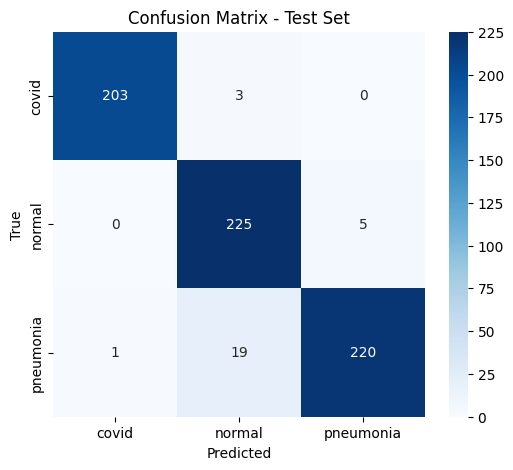

In [14]:
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

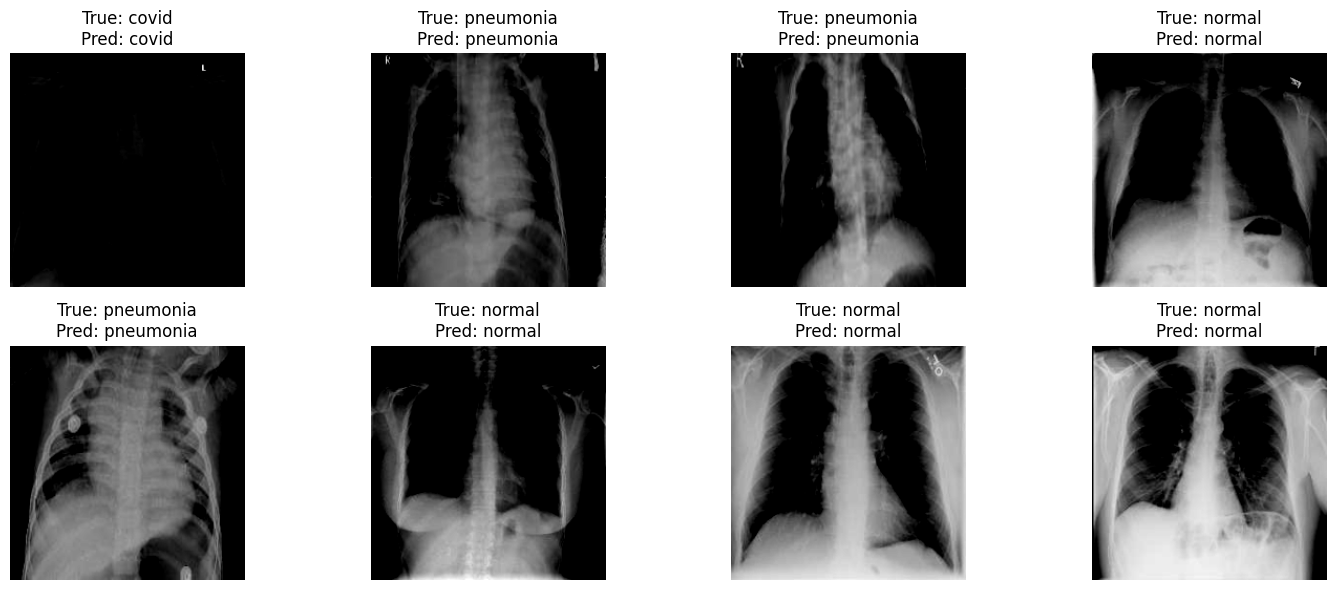

In [15]:
model.eval()
images_shown = 8
# Sample batch
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Handle one-hot encoded labels if necessary
if len(labels.shape) > 1 and labels.shape[1] > 1:
    true_labels = torch.argmax(labels, dim=1)
else:
    true_labels = labels
    
images, true_labels = images.to(device), true_labels.to(device)

outputs = model(images)

# Handle model output
if hasattr(outputs, 'logits'):
    logits = outputs.logits
else:
    logits = outputs
    
_, preds = torch.max(logits, 1)

plt.figure(figsize=(15, 6))
for i in range(min(images_shown, len(images))):
    ax = plt.subplot(2, 4, i+1)
    img = images[i].cpu().permute(1, 2, 0)
    
    # Normalize image for display
    if img.max() > 1:
        img = img / 255.0
    
    plt.imshow(img)
    
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        true_class = class_names[labels[i].argmax()]
    else:
        true_class = class_names[true_labels[i].item()]
        
    pred_class = class_names[preds[i].item()]
    
    ax.set_title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [ ]:
# Load the best weights
model.load_state_dict(torch.load("best_model.pth"))

# Save the full model
torch.save(model, "covid_pneumonia_classifier.pth")
print("Full model saved as covid_pneumonia_classifier.pth")

/tmp/ipykernel_117/757686956.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


✅ Full model saved as covid_pneumonia_classifier.pth


In [40]:
# Define the same preprocessing
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
    ToTensorV2()
])

# class_names = ['covid', 'normal', 'pneumonia']

# Load the image
img_path = os.path.join('/kaggle/input/pic-test/test2.jpg')
img = Image.open(img_path).convert('RGB')
img = np.array(img)
img = transform(image=img)['image'] 
img = img.unsqueeze(0).to(device)

# Load the model
model = torch.load('covid_pneumonia_classifier.pth', map_location=device)
model = model.to(device)
model.eval()

# Inference
with torch.no_grad():
    outputs = model(img)
    if hasattr(outputs, 'logits'):
        outputs = outputs.logits
    probs = torch.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probs, 1)

    predicted_class = class_names[predicted.item()]
    confidence = confidence.item() * 100

print(f"Predicted class: {predicted_class} ({confidence:.2f}% confidence)")

/tmp/ipykernel_117/2805496363.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('covid_pneumonia_classifier.pth', map_location=device)


Predicted class: covid (99.66% confidence)
